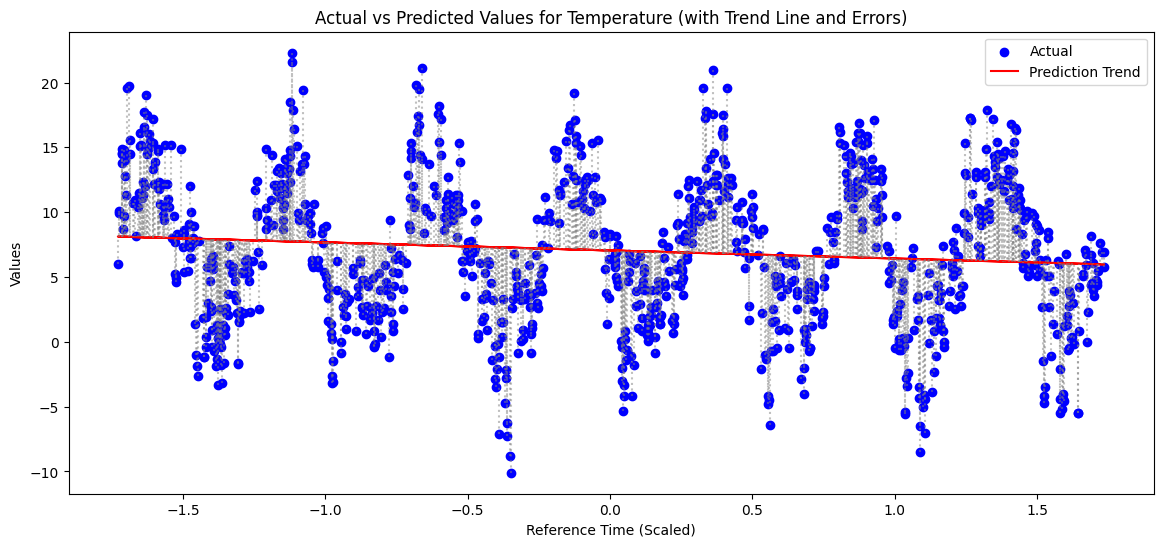

Mean Abspolute Error: 4.710056518223741
R-squared: 0.008854777516007939


In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Les inn data
temperature_data = pd.read_csv("../data/temperature_data.csv")

# Konverter referenceTime til datetime
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
temperature_data = temperature_data.dropna(subset=['referenceTime'])

X_regn = temperature_data['referenceTime']
Y_regn = temperature_data['value']

# Splitter dataene i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Omformer dataene til 2D-arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Skalering
scaler = StandardScaler()

# Passerer StandardScaler til dataene og transformerer deretter dataene.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# KOnverterer de skalerte arrayene tilbake til DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Trene en lineær regresjonsmodell og gjøre prediksjoner på testsettet
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predikere på testsettet
y_pred = regr.predict(X_test_scaled_df)

# Visualiserer prediksjoner vs faktiske verdier
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Temperature (with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



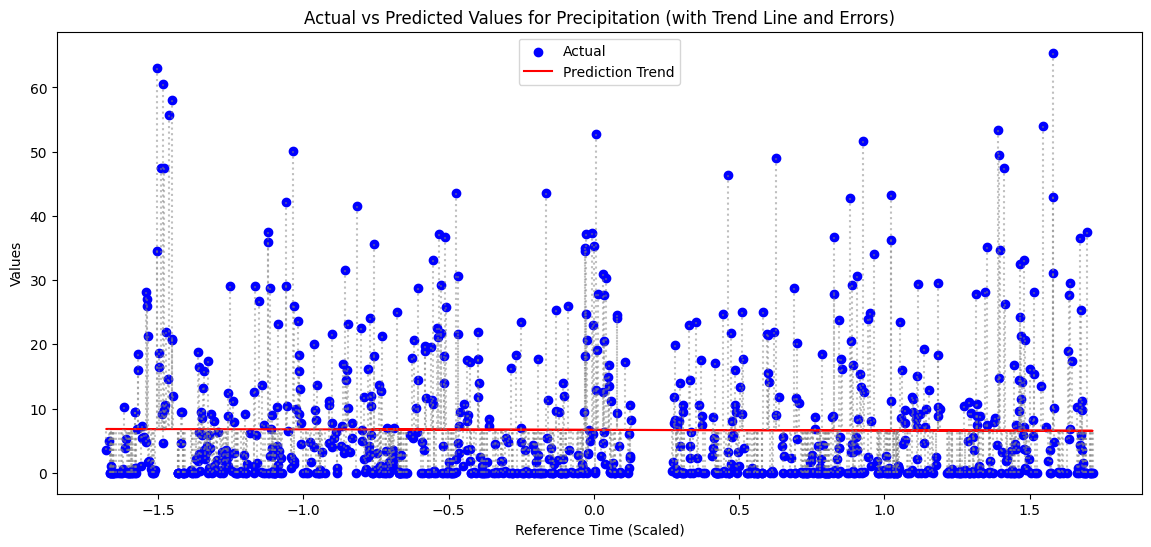

Mean Abspolute Error: 7.864078856670957
R-squared: -0.002640195287372249


In [4]:
# Les inn data
precipitation_data = pd.read_csv("../data/precipitation_data.csv")

# Konverter referenceTime til datetime
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
precipitation_data = precipitation_data.dropna(subset=['referenceTime'])

X_regn = precipitation_data['referenceTime']
Y_regn = precipitation_data['value']

# Splitter dataene i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Omformer dataene til 2D-arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Skalering
scaler = StandardScaler()

# Passerer StandardScaler til dataene og transformerer deretter dataene.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# KOnverterer de skalerte arrayene tilbake til DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Trene en lineær regresjonsmodell og gjøre prediksjoner på testsettet
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predikere på testsettet
y_pred = regr.predict(X_test_scaled_df)

# Visualiserer prediksjoner vs faktiske verdier
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Precipitation (with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



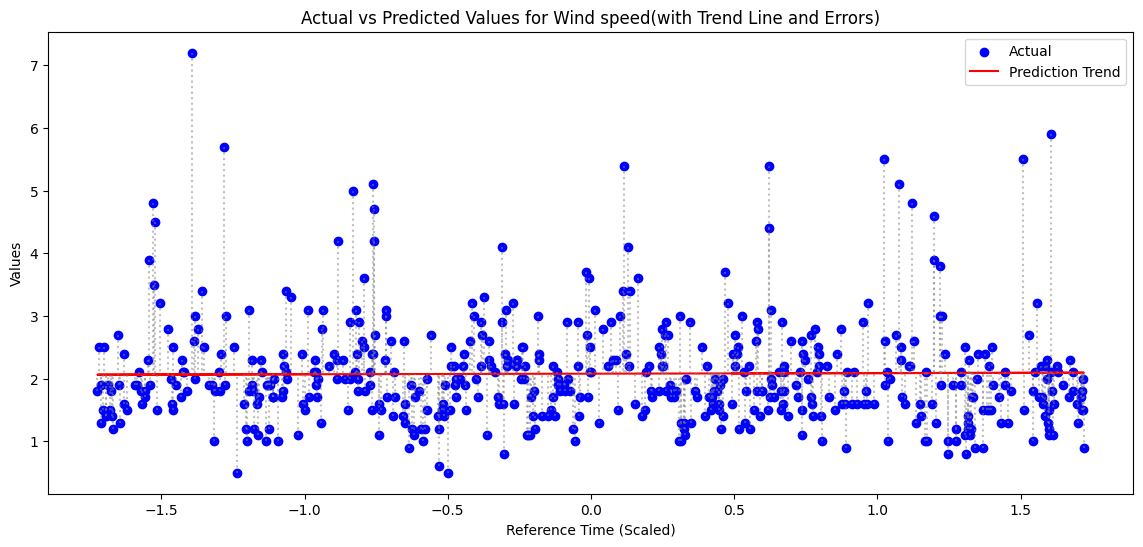

Mean Abspolute Error: 0.6044928037884653
R-squared: -0.0017114093400609764


In [6]:
# Les inn data
wind_speed_data = pd.read_csv("../data/wind_speed_data.csv")

# Konverter referenceTime til datetime
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
wind_speed_data = wind_speed_data.dropna(subset=['referenceTime'])

X_regn = wind_speed_data['referenceTime']
Y_regn = wind_speed_data['value']

# Splitter dataene i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Omformer dataene til 2D-arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Skalering
scaler = StandardScaler()

# Passerer StandardScaler til dataene og transformerer deretter dataene.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# KOnverterer de skalerte arrayene tilbake til DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Trene en lineær regresjonsmodell og gjøre prediksjoner på testsettet
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predikere på testsettet
y_pred = regr.predict(X_test_scaled_df)

# Visualiserer prediksjoner vs faktiske verdier
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Wind speed(with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



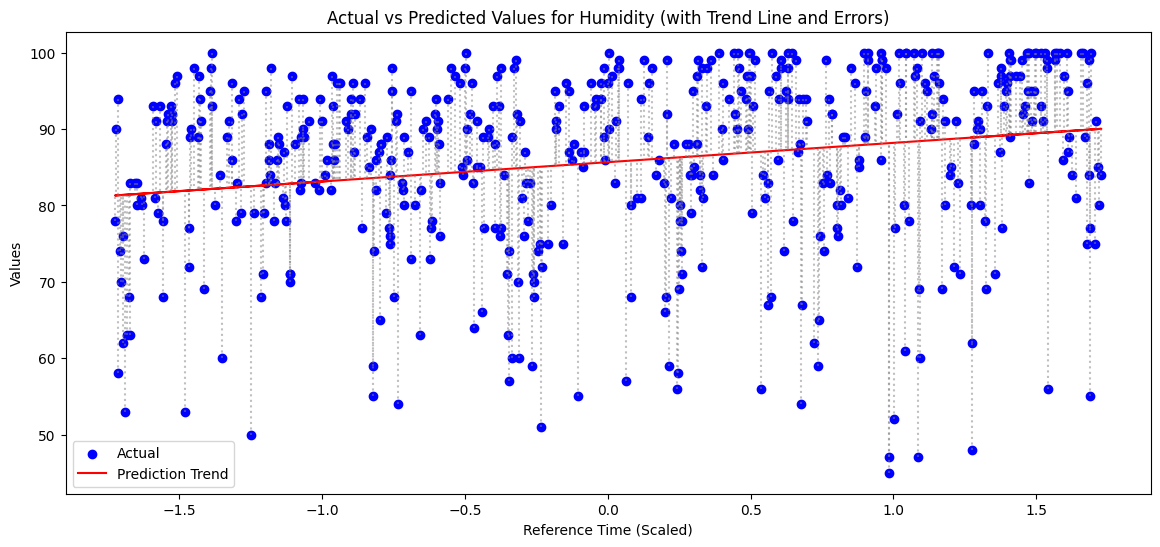

Mean Abspolute Error: 9.3627774321522
R-squared: 0.02900852748525118


In [7]:
# Les inn data
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverter referenceTime til datetime
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
humidity_data = humidity_data.dropna(subset=['referenceTime'])

X_regn = humidity_data['referenceTime']
Y_regn = humidity_data['value']

# Splitter dataene i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Omformer dataene til 2D-arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Skalering
scaler = StandardScaler()

# Passerer StandardScaler til dataene og transformerer deretter dataene.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# KOnverterer de skalerte arrayene tilbake til DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Trene en lineær regresjonsmodell og gjøre prediksjoner på testsettet
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predikere på testsettet
y_pred = regr.predict(X_test_scaled_df)

# Visualiserer prediksjoner vs faktiske verdier
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Humidity (with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



In [8]:
# Leser data fra de separate CSV-filene
temperature_data = pd.read_csv("../data/temperature_data.csv")
precipitation_data = pd.read_csv("../data/precipitation_data.csv")
wind_speed_data = pd.read_csv("../data/wind_speed_data.csv")
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverterer referansetiden til datetime for alle datasettene
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'])

# Plotter temperaturdata
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=temperature_data['value'],
    mode='lines',
    name='Temperatur',
    line=dict(color='#1f77b4')
))
mean_temp = temperature_data['value'].mean()
median_temp = temperature_data['value'].median()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=[mean_temp] * len(temperature_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittstemperatur'
))
fig_temp.update_layout(
    title=f"Temperatur over tid<br>Gjennomsnitt: {mean_temp:.2f} °C, Median: {median_temp:.2f} °C",
    xaxis_title="Dato",
    yaxis_title="Temperatur (°C)"
)
fig_temp.show()

# Plotter nedbørsdata
fig_precip = go.Figure()
fig_precip.add_trace(go.Bar(
    x=precipitation_data['referenceTime'],
    y=precipitation_data['value'],
    name='Nedbør',
    marker=dict(color='#1f77b4')
))
mean_precip = precipitation_data['value'].mean()
median_precip = precipitation_data['value'].median()
fig_precip.add_trace(go.Scatter(
    x=precipitation_data['referenceTime'],
    y=[mean_precip] * len(precipitation_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsnedbør'
))
fig_precip.update_layout(
    title=f"Nedbør over tid<br>Gjennomsnitt: {mean_precip:.2f} mm, Median: {median_precip:.2f} mm",
    xaxis_title="Dato",
    yaxis_title="Nedbør (mm)"
)
fig_precip.show()

# Plotter vindhastighetsdata
fig_wind = go.Figure()
fig_wind.add_trace(go.Scatter(
    x=wind_speed_data['referenceTime'],
    y=wind_speed_data['value'],
    mode='lines',
    name='Vindhastighet',
    line=dict(color='#1f77b4')
))
mean_wind = wind_speed_data['value'].mean()
median_wind = wind_speed_data['value'].median()
fig_wind.add_trace(go.Scatter(
    x=wind_speed_data['referenceTime'],
    y=[mean_wind] * len(wind_speed_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsvindhastighet'
))
fig_wind.update_layout(
    title=f"Vindhastighet over tid<br>Gjennomsnitt: {mean_wind:.2f} m/s, Median: {median_wind:.2f} m/s",
    xaxis_title="Dato",
    yaxis_title="Vindhastighet (m/s)"
)
fig_wind.show()

# Plotter luftfuktighetsdata
fig_humidity = go.Figure()
fig_humidity.add_trace(go.Scatter(
    x=humidity_data['referenceTime'],
    y=humidity_data['value'],
    mode='lines',
    name='Luftfuktighet',
    line=dict(color='#1f77b4')
))
mean_humidity = humidity_data['value'].mean()
median_humidity = humidity_data['value'].median()
fig_humidity.add_trace(go.Scatter(
    x=humidity_data['referenceTime'],
    y=[mean_humidity] * len(humidity_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittlig luftfuktighet'
))
fig_humidity.update_layout(
    title=f"Luftfuktighet over tid<br>Gjennomsnitt: {mean_humidity:.2f} %, Median: {median_humidity:.2f} %",
    xaxis_title="Dato",
    yaxis_title="Relativ luftfuktighet (%)"
)
fig_humidity.show()